# De-biasing standard deviation estimators

This post outlines the causes and remedies for the bias inherant in estimating the standard deviation (SD) of a random variable. The SD is simply the square root of the variance, making them both population parameters. While the well-known sample variance estimator provides an unbiased estimate of its population parameter, the equivalent sample SD estimator does not, as unbiased statistical estimators are not (in general) invariant to concave or convex transformations. When the data are Gaussian, than the bias of the sample SD is exactly characterize and can be offset with an analytical term. In the non-normal case however, the magnitude of the bias will be a function of the distribution's parameters, and adjustment factors can be estimating either parametrically or non-parametrically.

Describing and mitigating the bias in estimating the SD is not a new topic, and for more recent treatments on the topic see Dr. Dave Giles blog post [Unbiased Estimation of a Standard Deviation](https://davegiles.blogspot.com/2013/12/unbiased-estimation-of-standard.html) and this working paper [Giles (2021)](http://web.uvic.ca/~dgiles/downloads/working_papers/std_dev.pdf). Section 2 of this post draws heavily on the latter. 

The motivation for this blog post is four fold.

1. Summarize the key insights already found in the literature in a readable and accessible way.
2. Provide up-to-date `python` code (new) that provides Monte Carlo evidence on how the various de-biasing strategies work.
3. Demonstrate novel empirical results for trade-off de-biasing strategies (i.e. the MSE of the estimator).
4. Show how these techniques can be used in an applied regression setting.

This post was generated from an original notebook that can be found HERE. For readability, various code blocks have been supressed and the text has been tidied up.

<br>



## (1) Background

It is well understood that the [sample variance](https://en.wikipedia.org/wiki/Variance#Unbiased_sample_variance), denoted throughout as $S^2$, is an unbiased estimate of the variance for any well-behaved continuous distribution.

<br>

$$
\begin{align*}
X &\sim F \hspace{2mm} \text{where $F$ is some continuous dist} \\
\text{Var}(X) &= E([X - E(X)]^2) \\
S^2 &= (n-1)^{-1} \sum_{i=1}^n (X_i - \bar{X})^2 \\ 
\bar{X} &= n^{-1} \sum_{i=1}^n X_i \\
(n-1) E[S^2] &= \sum_{i=1}^n E[(X_i - \mu)^2] - nE[(\bar{X} - \mu)^2] \\
&= \sum_{i=1}^n \sigma^2 - n \text{Var}(\bar{X}) \\
&= n\sigma^2 - n \frac{\sigma^2}{n} \\
&= (n-1) \sigma^2 \hspace{2mm} \longleftrightarrow \\
E[S^2] &= \sigma^2
\end{align*}
$$

This fact is pretty remarkable. For any finite sample, using [Bessel's correction](https://en.wikipedia.org/wiki/Bessel%27s_correction) provides an unbiased estimate of the second moment of any continuous distribution. Of course, the variance of the sample variance estimator $S^2$ will be inversely proportional to the sample size, but these standard errors can be estimated using the standard non-parametric approaches like the bootstrap.[[^1]] While $S^2$ is an unbiased estimate of the population variance, will $S$ be an unbiased estimate of the population standard deviation?

The short answer is no: an unbiased estimator is generally not invariant under parameter transformations. Why is this the case? It's because of [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality#Probabilistic_form): the function of an expectation of a random variable, will not (in general) be equal to the expectation of a function of a random variable. 

$$
\begin{align*}
\text{SD}(X) &= \sqrt{\text{Var}(X)} \\
&= \sqrt{E([X - E(X)]^2)} = \sqrt{\sigma^2} = \sigma \\
E[S^2] &=  (n-1)^{-1} \sum_{i=1}^n E(X_i - \bar{X})^2 = \sigma^2 \\
E[S] &= E\Bigg\{ \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})^2 \Bigg\}^{0.5} \\
&\neq \sigma \hspace{2mm} \text{ by Jensen's inequality}
\end{align*}
$$

In this instance, $S^2$ is the random variable, and the function is a square root transformation. In fact, Jensen's inequality tells us that:

$$
\begin{align*}
E[f(S^2)] &\leq f(E[S^2]) \\
E[S] &\leq \sigma
\end{align*}
$$

When $f(\cdot)$ is a [concave function](https://en.wikipedia.org/wiki/Concave_function), which the square-root transformation is. In other words, taking the square root of the sample variance (i.e. the sample standard deviation) will lead to an under-estimate of the true population standard deviation. However, it's important to note that $S$ is still a consistent estimator of $\sigma$ because $\text{Var}(S^2) \to 0$ as $n \to \infty$ so $S \overset{p}{\to} \sigma$. In other words, while $S$ is biased, it is still consistent. The simulation example below shows both the bias and consistency visually.

### Simulation showing bias

Consider a simple single-parameter [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution), $X \sim \text{Exp}(\lambda)$ where $\lambda$ is the rate parameter. The moments of the exponential distribution are well defined: $E[X]=\lambda^{-1}$, $E[(X-\lambda^{-1})^2]=\lambda^{-2}$, and so on. The simulation below will consider three different values of $\lambda = \{1/2, 1, 2\}$, and 7 different finite sample sizes: $n=\{2^1, 2^2, \dots, 2^7\}$, and compare the oracle variance and standard deviation to their empirical counterparts.

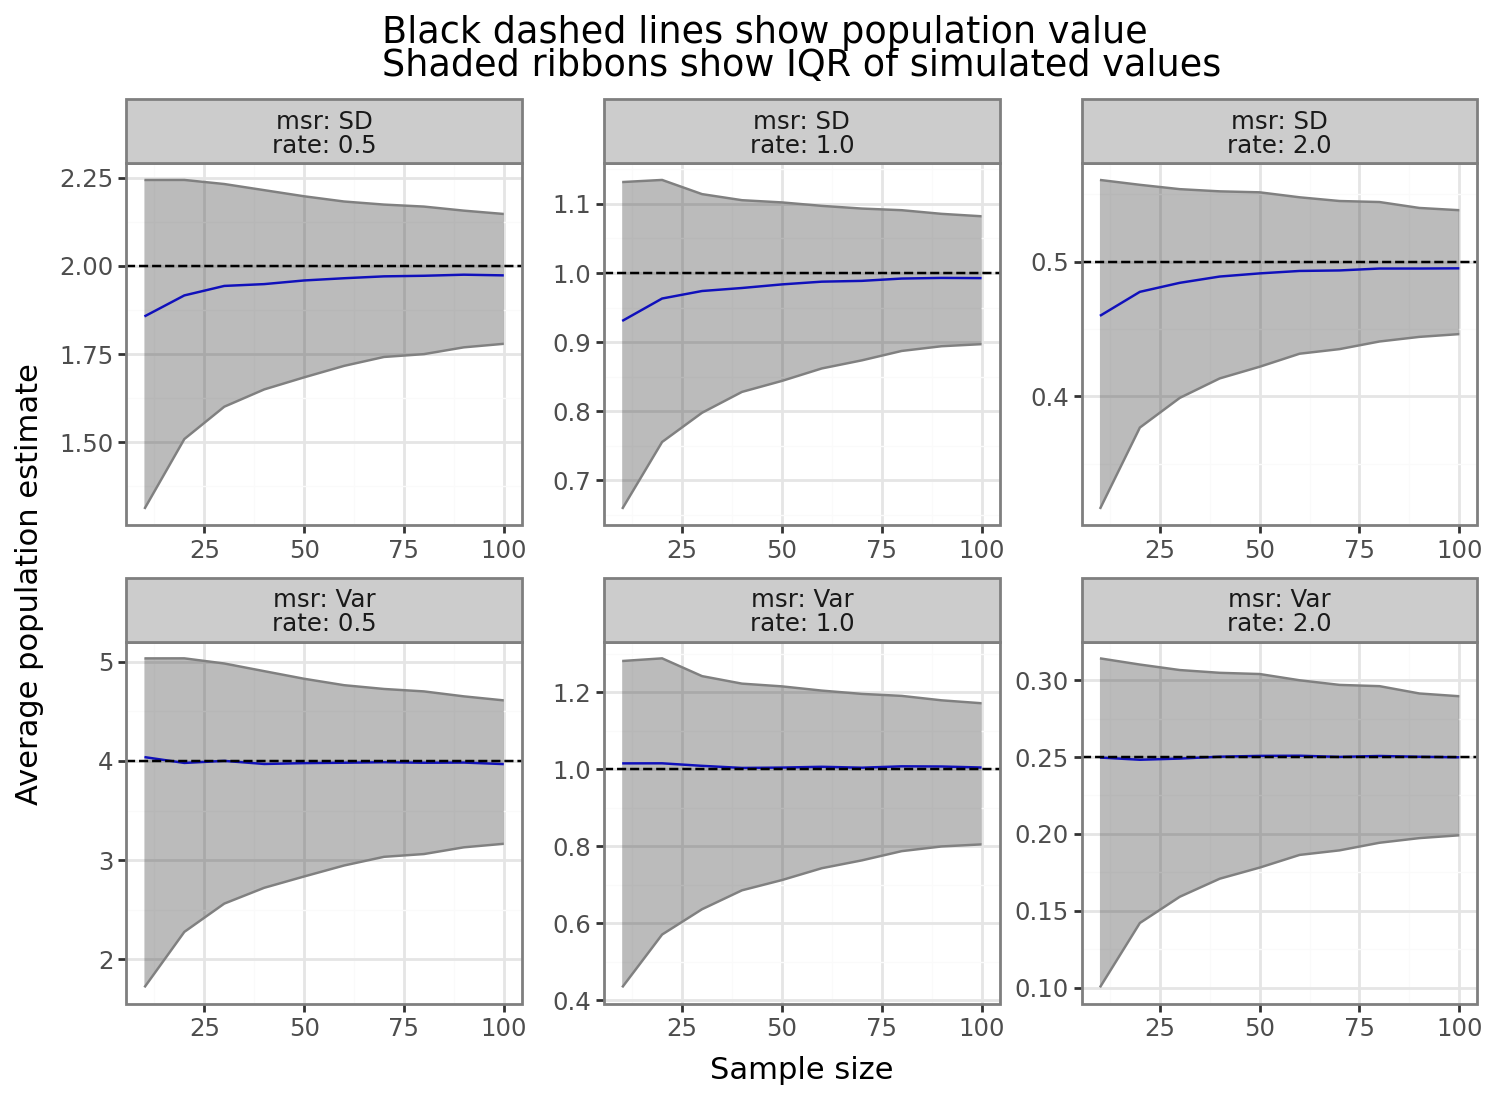

In [1]:
# Import modules to be used throughout post
import numpy as np
import pandas as pd
import plotnine as pn
from scipy.stats import norm, expon
from utils import calculate_summary_stats

nsim = 2500  # Number of simluations
sample_sizes = np.arange(10, 100+1, 10).astype(int)
n_sample_sizes = len(sample_sizes)
rates = np.array([1/2, 1, 2])
n_rates = len(rates)
dist_expon = expon(scale = 1 / rates)
oracle_variance = dist_expon.var()
oracle_sd = np.sqrt(oracle_variance)
# Calculate the oracle quantities
dat_oracle_expon = pd.concat(objs = [pd.DataFrame({'msr':'Var', 'rate':rates, 'oracle':oracle_variance}),
                                     pd.DataFrame({'msr':'SD', 'rate':rates, 'oracle':oracle_sd})])
# Run the simulation
holder_var = np.zeros((nsim, n_sample_sizes, n_rates))
for i in range(nsim):
    sim_var_i = np.vstack([dist_expon.rvs(size=(n, n_rates), random_state=i+1).var(ddof=1, axis=0) for n in sample_sizes])
    holder_var[i] = sim_var_i
# Calculate average results with some variation
res_var = calculate_summary_stats(holder_var, colnames=rates, idxnames=sample_sizes, var_name='rate', value_name='n')
res_sd = calculate_summary_stats(np.sqrt(holder_var), colnames=rates, idxnames=sample_sizes, var_name='rate', value_name='n')
res_expon = pd.concat(objs = [res_var.assign(msr='Var'), res_sd.assign(msr='SD')])

pn.options.figure_size = (7.5, 5.5)
gg_expon = (pn.ggplot(res_expon, pn.aes(x='n', y='mu')) + 
            pn.theme_bw() + pn.geom_line(color='blue') + 
            pn.geom_ribbon(pn.aes(ymin='lb', ymax='ub'),color='grey', alpha=1/3) + 
            pn.facet_wrap('~msr+rate', scales='free', labeller=pn.label_both, nrow=2, ncol=3) + 
            pn.geom_hline(pn.aes(yintercept='oracle'), data=dat_oracle_expon,linetype='--') + 
            pn.labs(y='Average population estimate', x='Sample size') + 
            pn.ggtitle('Black dashed lines show population value\nShaded ribbons show IQR of simulated values'))
gg_expon

As the figure above shows, the sample variance (second panel row) is unbiased, and interestingly nonsymmetric, around the true value for this exponential distribution for all sample sizes. In other words, the distribution is certainly not normal, but it is mean zero around the population parameter. In contrast, the bias of the sample standard deviation is negative and inversely proportional to the sample size. Is there anything we can do to address this bias? 

## (2) De-biasing adjustment strategy

If $E[S] \leq \sigma$ because of the concave square-root transform, then can some adjustment factor be applied to sample SD to correct for this? Specifically, we are interesting in finding some deterministic $C_n$ such that:

$$
\sigma \approxeq C_n E[S]
$$

Before further derivations, it should be intuitive that $\underset{n\to \infty}{\lim} C_n = 1$, since the sample SD is consistent (but biased) and the exact form will vary for different parametric distributions.[[^2]] The rest of this section is broken down into. First, I present the well-known solution for when the data is Gaussian. Second, I show how a series expansion can provide up to three-orders of analytic adjustments to account for the bias in $S$. The subsequent section will provide simulation evidence for how well this works in the parametric and non-parametric case.

### (2.1) Normally distributed data

When $X \sim N(\mu, \sigma^2)$, then an exact adjustment factor has been known since [Holtzman (1950)](https://psycnet.apa.org/record/1951-04161-001), and be calculated by simply working through the expectation of a power transformation of a chi-squared couplied with the fact that the sample variance of Gaussian is chi-squared: 


$$
\begin{align*}
S^2 &\sim \frac{\sigma^2}{n-1} \cdot \chi^2(n-1) \hspace{2mm} \text{ when $X$ is Gaussian} \\
E[Q^p] &= \int_0^\infty \frac{x^p x^{k/2-1} e^{-x/2}}{2^{k/2} \Gamma(k/2)} dx, \hspace{2mm} \text{ where } Q \sim \chi^2(k) \\
&= \frac{2^{p+k/2}}{2^{k/2} \Gamma(k/2)} \int_0^\infty z^{p+k/2-1} e^{-z} dz,  \hspace{2mm} \text{ where } x = 2z \\
&= \frac{2^{m}}{2^{m-p} \Gamma(m-p)} \underbrace{\int_0^\infty z^{m-1} e^{-z} dx}_{\Gamma(m)},  \hspace{2mm} \text{ where } m = p + k/2 \\
&= 2^p \cdot \frac{\Gamma(k/2+p)}{\Gamma(k/2)} \\
E\Bigg[ \Bigg( \frac{(n-1)S^2}{\sigma^2} \Bigg)^{1/2} \Bigg] &= \frac{\sqrt{2} \cdot \Gamma(n/2)}{\Gamma([n-1]/2)} \\
E[ S ] &= \sigma \cdot \sqrt{\frac{2}{n-1}} \cdot \frac{\Gamma(n/2)}{\Gamma([n-1]/2)}  \\
C_n &= \sqrt{\frac{n-1}{2}} \cdot \frac{\Gamma([n-1]/2)}{\Gamma(n/2)} \\
E[ S \cdot C_n ] &= \sigma
\end{align*}
$$

Where $\Gamma(\cdot)$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function). The code block below shows that this adjustment factor works as expected.

In [2]:
from scipy.special import gamma as GammaFunc
from scipy.special import gammaln as LogGammaFunc

# Adjustment factor
def C_n_gaussian(n: int, approx:bool = True) -> float:
    if approx:
        gamma_ratio = np.exp(LogGammaFunc((n-1)/2) - LogGammaFunc(n/2))
    else:
        gamma_ratio = GammaFunc((n-1)/2) / GammaFunc(n / 2)
    return np.sqrt((n - 1)/2) * gamma_ratio

# Set up simulation parameters
nsim = 100000
sample_sizes = np.linspace(2, 50, num=25).astype(int)
mu = 1.3
sigma2 = 5
sigma = np.sqrt(sigma2)
dist_norm = norm(loc = mu, scale = sigma)
# Try sample STD
S_gauss_raw = np.vstack([dist_norm.rvs(size = (nsim, n), random_state=1).std(axis=1, ddof=1) for n in sample_sizes]).mean(axis=1)
S_gauss_adj = C_n_gaussian(sample_sizes) * S_gauss_raw
res_gauss = pd.DataFrame({'n':sample_sizes,'raw':S_gauss_raw, 'adj':S_gauss_adj}).\
    melt('n', var_name='msr', value_name='sd')


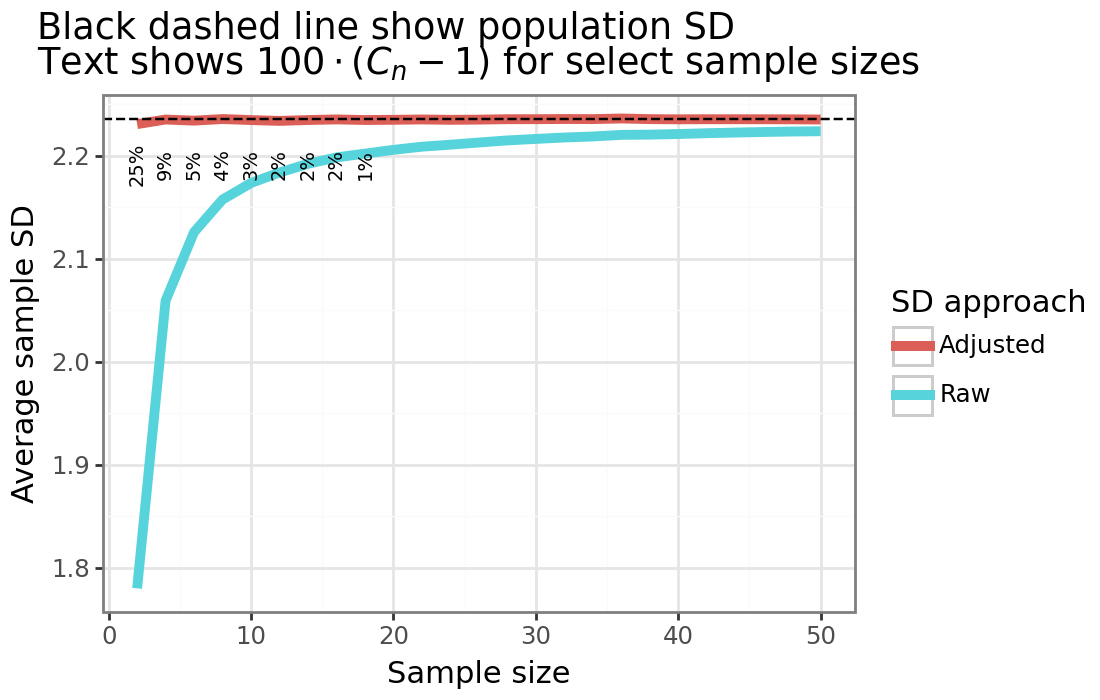

In [3]:
dat_adj_gauss = pd.DataFrame({'n':sample_sizes, 'adj':C_n_gaussian(sample_sizes)}).head(9)

pn.options.figure_size = (5.5, 3.5)
di_gauss_lbl ={'raw': 'Raw', 
               'adj': 'Adjusted'}
gg_gauss = (pn.ggplot(res_gauss, pn.aes(x='n', y='sd', color='msr')) + 
            pn.theme_bw() + 
            pn.geom_line(size=2) + 
            pn.geom_hline(yintercept=sigma, linetype='--') + 
            pn.geom_text(pn.aes(label='(adj-1)*100', y=sigma*0.98), size=7, color='black', format_string='{:.0f}%', angle=90, data=dat_adj_gauss) + 
            pn.scale_color_discrete(name='SD approach', labels = lambda x: [di_gauss_lbl[z] for z in x]) + 
            pn.labs(y='Average sample SD', x='Sample size') + 
            pn.ggtitle('Black dashed line show population SD\nText shows $100\cdot (C_n-1)$ for select sample sizes'))
gg_gauss

The figure above shows that the sample SD can be correctly adjusted for with $C_n$ from EQREF. For very small sample sizes this adjustment is substantial, and requires a maximum increase of 25% (when $n=2$). However, by around 20 samples in the Gaussian case, the adjustment factor will be 1% or less.

### (2.2) Series expansion of the sample SD


First, consider re-writing $S$ as a function of $\sigma$ (you'll notice the RHS reduces to $S$):

$$
S = \sigma [1 + (S^2 - \sigma^2)/\sigma^2]^{1/2}
$$

Next, consider the [binomial series expansion](https://en.wikipedia.org/wiki/Binomial_series):

$$
(1 + x)^{0.5} = 1 + \frac{x}{2} - \frac{x^2}{8} + \frac{x^3}{16} - \dots
$$

Re-writing $x = (S^2 - \sigma^2)/\sigma^2$ we see that:

$$
S = \sigma \Bigg[1 + \frac{1}{2\sigma^2}(S^2 - \sigma^2) - \frac{1}{8\sigma^4}([S^2 - \sigma^2]^2) + \frac{1}{16\sigma^6}([S^2 - \sigma^2]^3) - \dots \Bigg]
$$

Now that we've re-written the sampling SD in terms of an infinite series and removed the square-root, we need to understand how fast the high-order terms tend towards zero as $n$ increases. Remember, $S^2$ is an unbiased estimator of $\sigma^2$ so $S^2-\sigma^2$ always averages to zero, and what we're interested in understanding is how fast the variance decreases. For example, when $X$ comes from a normal distribution, then:

$$
\begin{align*}
S^2 - \sigma^2 &= \sigma^2 \Bigg( \frac{\chi^2_{n-1}}{n-1} -1 \Bigg) \\
&\approx \sigma^2 \cdot N\Bigg(0, \frac{2}{n-1} \Bigg) \\
&\sim N\Bigg(0, \frac{2\sigma^4}{n-1} \Bigg),
\end{align*}
$$

Using the [well-known fact](https://en.wikipedia.org/wiki/Chi-squared_distribution#Related_distributions) that $\chi^2_k \overset{d}{\to} N(k, 2k)$. What's nice is that the sampling distribution actually follows a chi-square distribution [asymptotically](https://stats.stackexchange.com/questions/105337/asymptotic-distribution-of-sample-variance-of-non-normal-sample) for any continuous RV, so we can use the above results for the sampling variance more generally:

$$
\begin{align*}
\frac{S^2 - \sigma^2}{\sigma^2} &\approx \sqrt{\frac{2}{n-1}} Z, \hspace{2mm} Z \sim N(0,1) \\
O\Bigg( \sqrt{\frac{2}{n-1}} Z \Bigg) &= O\Bigg( \frac{1}{\sqrt{n}} \Bigg)  \\
O\Bigg( \frac{S^2 - \sigma^2}{\sigma^2}\Bigg) &= O(n^{-1/2}) \\
O\Bigg( \Bigg[ \frac{S^2 - \sigma^2}{\sigma^2} \Bigg]^k \Bigg) &= O(n^{-k/2})
\end{align*}
$$

We can see that the random variable $(S^2 - \sigma^2)/\sigma^2$ has a sampling error that is root-n consistent. And each time this term is raised to the power of $k$, the sampling error decreases by a rate of $k/2$. When $n$ is large, then $O(n^{-0.5})$ implies that that the sample size needs increase by 4x, for the estimator's standard error to fall by 1/2. Whereas for $O(n^{-1})$ and $O(n^{-1.5})$ when the sample size doubles and increases by 59%, respectively, the standard error will halve. More generally, the formula to halve the SE will be: $n' = 2^{k / 2} n$, or alternatively, for a doubling of the sample size, the SE will decrease by: $2^{-k/2}$.

Let's check that this is indeed true for the exponential distrubiton: namely, when $n$ is large, if $n' = 2n$, then the standard error of $(S^2 - \sigma^2)/\sigma^2$ will decrease by around $2^{-k/2}$. In the simulation below we'll use the same three Exponential distribution described above, and compare $\hat{\text{SD}}(S^2) = \text{SE}(S^2)$ when $n=1000$ vs $n'=2000$ over 2500 simulations.

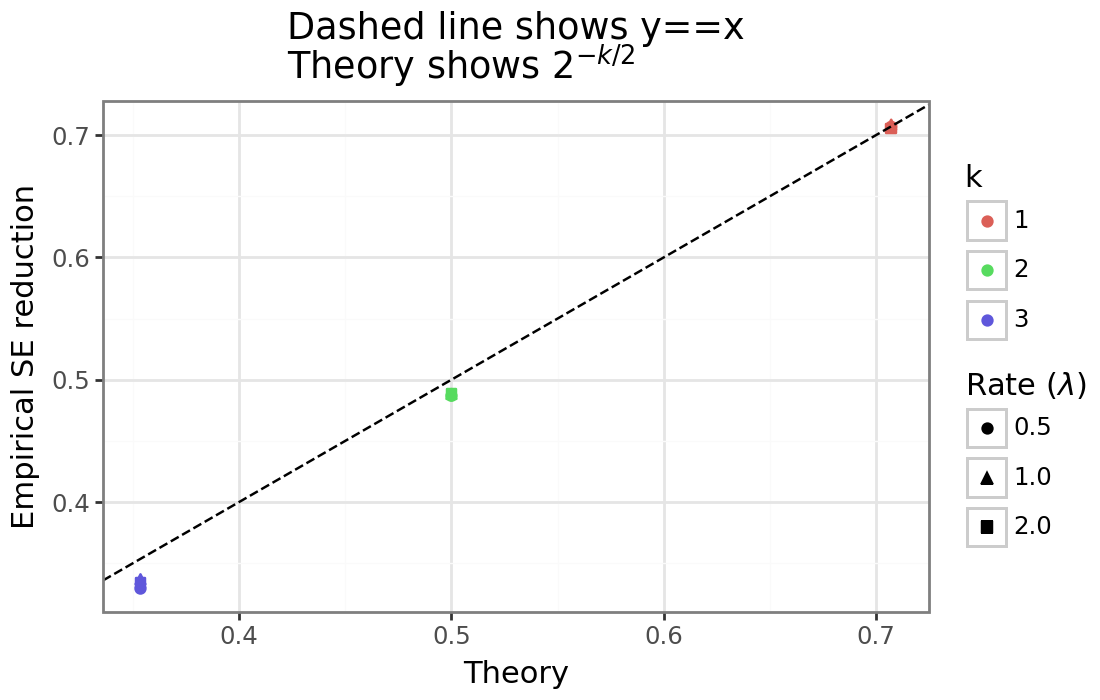

In [4]:
# oracle_variance
n = 1000
nprime = int(2 * n)
S2_n = dist_expon.rvs(size = (n, nsim, n_rates), random_state=1).var(ddof=1, axis=0)
S2_nprime = dist_expon.rvs(size = (nprime, nsim, n_rates), random_state=2).var(ddof=1, axis=0)
# Normalize to oracle variance
norm_var_n = (S2_n - oracle_variance) / oracle_variance
norm_var_nprime = (S2_nprime - oracle_variance) / oracle_variance
sd_rate_1 = np.std(norm_var_nprime, axis=0, ddof=1) / np.std(norm_var_n, axis=0, ddof=1)
sd_rate_2 = np.std(norm_var_nprime**2, axis=0, ddof=1) / np.std(norm_var_n**2, axis=0, ddof=1)
sd_rate_3 = np.std(norm_var_nprime**3, axis=0, ddof=1) / np.std(norm_var_n**3, axis=0, ddof=1)
# Calculate the theoretical decrease
rate_theory = pd.DataFrame({'k':[1, 2, 3]}).assign(theory=lambda x: 2**(-x['k']/2))
# Plot it
res_order = pd.DataFrame({'rate':rates, 1:sd_rate_1, 2:sd_rate_2, 3:sd_rate_3 }).\
    melt('rate', var_name='k', value_name='emp').\
    merge(rate_theory)

pn.options.figure_size = (5.5, 3.5)
gg_se_theory = (pn.ggplot(res_order, pn.aes(x='theory', y='emp', color='k.astype(str)', shape='rate.astype(str)'))+ 
          pn.theme_bw() + pn.geom_point() + 
          pn.labs(y='Empirical SE reduction', x='Theory') + 
          pn.ggtitle('Dashed line shows y==x\nTheory shows $2^{-k/2}$') + 
          pn.scale_color_discrete(name='k') + 
          pn.scale_shape_discrete(name='Rate ($\\lambda$)') + 
          pn.geom_abline(slope=1, intercept=0,linetype='--'))
gg_se_theory

The figure above shows that we achieve the variance reduction as expected. As $n$ and the number of simulations gets larger, the results will become increasingly exact. We can no conservatively approximate $S$ using the first three terms plus some term that goes away at a quadratic rate:

$$
S = \sigma \Bigg[1 + \frac{1}{2}\frac{S^2 - \sigma^2}{\sigma^2} - \frac{1}{8}\Big(\frac{S^2 - \sigma^2}{\sigma^2}\Big)^2 + \frac{1}{16}\Big(\frac{S^2 - \sigma^2}{\sigma^2}\Big)^3 \Bigg] + O(n^{-2})
$$

Since $E[S^2 - \sigma^2] = 0$, we can calculate the approximate expectation of $S$ by:


$$
E[S] \approxeq \sigma \Bigg[1 - \frac{1}{8}\Big(\frac{E[S^2 - \sigma^2]^2}{\sigma^4}\Big) + \frac{1}{16}\Big(\frac{E[S^2 - \sigma^2]^3}{\sigma^6}\Big) \Bigg]
$$

Next we need to figure out what $E[S^2 - \sigma^2]^k$ is for $k = \{2, 3\}$. Luckily, [Angelova (2012)](https://ijpam.eu/contents/2012-79-1/7/7.pdf) has already done this up to $k=4$ (see equation 19), which is shown below for convenience.

## References

[^1]: And if the data is Gaussian, the sample variance actually has a chi-squared distribution and therefore *exact* confidence intervals can be generated.

[^2]: Note that an alternative formulation a la [Cureton (1968)](https://www.tandfonline.com/doi/pdf/10.1080/00031305.1968.10480435) is to re-write the sample SD as $S = \sqrt{\sum_i (X_i \bar{X})^2 / k_n}$ so that we have a different adjustment factor that the usual Bessel Correction.